In [1]:
# general tools
import sys
import time
from glob import glob

# data tools
import zarr
import h5py
import random
from datetime import datetime, timedelta
import numpy as np
from random import shuffle
from scipy.spatial import cKDTree

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import dask.array as da

In [3]:
# deep learning tools
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
tf.config.run_functions_eagerly(True)

# from keras_unet_collection import models as k_models
from keras_unet_collection import utils as k_utils
# from keras_unet_collection import layer_utils as k_layers
# from keras_unet_collection.activations import GELU

2022-09-22 11:54:37.431193: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [4]:
sys.path.insert(0, '/glade/u/home/ksha/NCAR/')
sys.path.insert(0, '/glade/u/home/ksha/NCAR/libs/')

from namelist import *
import data_utils as du
import graph_utils as gu
import convnext_keras as ck

In [5]:
from keras_unet_collection import utils as k_utils

In [6]:
lead = 2

### Import data

In [7]:
names = [
    'Maximum/Composite radar reflectivity:dB (instant):lambert:atmosphere:level 0',
    'MSLP (MAPS System Reduction):Pa (instant):lambert:meanSea:level 0',
    'AGL reflectivity (max):lambert:heightAboveGround:level 1000 m',
    'Updraft helicity (max):lambert:heightAboveGroundLayer:levels 5000-2000 m',
    'Updraft helicity (max):lambert:heightAboveGroundLayer:levels 2000-0 m',
    'Updraft helicity (max):lambert:heightAboveGroundLayer:levels 3000-0 m',
    'Vorticity (relative):s**-1 (max):lambert:heightAboveGroundLayer:levels 2000-0 m',
    'Vorticity (relative):s**-1 (max):lambert:heightAboveGroundLayer:levels 1000-0 m',
    'Column integrated graupel mass (max):lambert:atmosphereSingleLayer:level 0 considered as a single layer',
    '2 metre temperature:K (instant):lambert:heightAboveGround:level 2 m',
    '2 metre dewpoint temperature:K (instant):lambert:heightAboveGround:level 2 m',
    '10 metre U wind component:m s**-1 (instant):lambert:heightAboveGround:level 10 m',
    '10 metre V wind component:m s**-1 (instant):lambert:heightAboveGround:level 10 m',
    '10 metre wind speed:m s**-1 (max):lambert:heightAboveGround:level 10 m',
    'Total Precipitation:kg m**-2 (accum):lambert:surface:level 0',
    'Convective available potential energy:J kg**-1 (instant):lambert:surface:level 0',
    'Convective inhibition:J kg**-1 (instant):lambert:surface:level 0',
    'Storm relative helicity:J kg**-1 (instant):lambert:heightAboveGroundLayer:levels 3000-0 m',
    'Storm relative helicity:J kg**-1 (instant):lambert:heightAboveGroundLayer:levels 1000-0 m',
    'Vertical u-component shear:s**-1 (instant):lambert:heightAboveGroundLayer:levels 0-1000 m',
    'Vertical v-component shear:s**-1 (instant):lambert:heightAboveGroundLayer:levels 0-1000 m',
    'Vertical u-component shear:s**-1 (instant):lambert:heightAboveGroundLayer:levels 0-6000 m',
    'Vertical v-component shear:s**-1 (instant):lambert:heightAboveGroundLayer:levels 0-6000 m'
]

In [8]:
means = [
    -6.335041783675384,
    101598.30648208999,
    2.4340308170812857,
    0.0238316214287872,
    0.0115228964831135,
    0.015723252607236175,
    0.00010298927478466365,
    0.00013315081911787703,
    0.02022990418418194,
    285.1588453352469,
    280.69456763975046,
    0.18025322895802864,
    -0.35625256772098957,
    4.466962100212334,
    0.10710428466431396,
    311.51020050786116,
    -22.95554152474839,
    95.80303950026172,
    41.22773039479408,
    2.696538199313979,
    0.257023643073863,
    11.80181492281666,
    0.15778718430103703,
];

stds = [
    8.872575669978966,
    672.3339463894478,
    7.555104640235371,
    0.5696550725786566,
    0.2283199203388272,
    0.37333362094670486,
    0.00022281640603195643,
    0.0002413561909874066,
    0.3589573748563584,
    11.553795616392204,
    12.101590155483459,
    3.1758721705443826,
    3.6588052023281175,
    2.6995797278745948,
    0.9896017905552607,
    748.8376068157106,
    78.895180023938,
    104.17948262883918*2,
    77.25788246299936*2,
    5.35086729614372,
    5.438075471238217,
    11.440203318938076,
    11.327741531273508
];



log_norm = [True, False, True, True, True, True, True, True, True, False, False, 
            False, False, True, True, True, True, False, False, False, False, False, False]

In [9]:
with h5py.File(save_dir+'HRRR_domain.hdf', 'r') as h5io:
    lon_3km = h5io['lon_3km'][...]
    lat_3km = h5io['lat_3km'][...]
    lon_72km = h5io['lon_72km'][...]
    lat_72km = h5io['lat_72km'][...]

In [10]:
base_v3_s = datetime(2018, 7, 15)
base_v3_e = datetime(2020, 12, 2)

base_v4_s = datetime(2020, 12, 3)
base_v4_e = datetime(2022, 7, 15)

base_ref = datetime(2010, 1, 1)

date_list_v3 = [base_v3_s + timedelta(days=day) for day in range(365+365+142)]
date_list_v4 = [base_v4_s + timedelta(days=day) for day in range(365+180)]

In [11]:
day_start = 675
day_end = 872
N_days = day_end - day_start

In [12]:
HRRRv3_lead = da.from_zarr(save_dir_scratch+'HRRR_{:02}_v3.zarr'.format(lead))

#HRRRv3_lead = np.zeros((872, 1059, 1799, 23))

### Import pre-trained model

In [13]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend
from tensorflow.keras import layers
from tensorflow.keras import utils
from tensorflow.keras import Model

  
class LayerScale(layers.Layer):
    """Layer scale module.
    References:
      - https://arxiv.org/abs/2103.17239
    Args:
      init_values (float): Initial value for layer scale. Should be within
        [0, 1].
      projection_dim (int): Projection dimensionality.
    Returns:
      Tensor multiplied to the scale.
    """

    def __init__(self, init_values, projection_dim, **kwargs):
        super().__init__(**kwargs)
        self.init_values = init_values
        self.projection_dim = projection_dim

    def build(self, input_shape):
        self.gamma = tf.Variable(
            self.init_values * tf.ones((self.projection_dim,))
        )

    def call(self, x):
        return x * self.gamma

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "init_values": self.init_values,
                "projection_dim": self.projection_dim,
            }
        )
        return config
    


def Head(num_classes=1000, name=None):
    """Implementation of classification head of RegNet.
    Args:
      num_classes: number of classes for Dense layer
      name: name prefix
    Returns:
      Classification head function.
    """
    if name is None:
        name = str(backend.get_uid("head"))

    def apply(x):
        x = layers.GlobalAveragePooling2D(name=name + "_head_gap")(x)
        x = layers.LayerNormalization(
            epsilon=1e-6, name=name + "_head_layernorm"
        )(x)
        x = layers.Dense(num_classes, name=name + "_head_dense")(x)
        return x

    return apply


In [14]:
depths=[3, 3, 27, 3]
projection_dims=[96, 192, 384, 768]
drop_path_rate=0.0
layer_scale_init_value=1e-6
model_name='test'
input_shape=(64, 64, 23)
classes=1

IN = layers.Input(shape=input_shape)
X = IN

num_convnext_blocks = 4

# ----- convnext block 0 ----- #

X = layers.Conv2D(projection_dims[0], kernel_size=4, strides=4, name="{}_down0".format(model_name))(X)
X = layers.LayerNormalization(epsilon=1e-6, name="{}_down0_norm".format(model_name))(X)

for j in range(depths[0]):
    
    X_convnext = X
    X_convnext = layers.Conv2D(filters=projection_dims[0], kernel_size=7, padding="same",
                               groups=projection_dims[0], name="{}_down0_dconv{}".format(model_name, j))(X_convnext)
    X_convnext = layers.LayerNormalization(epsilon=1e-6, name="{}_down0_dconv{}_norm".format(model_name, j))(X_convnext)
    X_convnext = layers.Dense(4 * projection_dims[0], name="{}_down0_dense{}_p1".format(model_name, j))(X_convnext)
    X_convnext = layers.Activation("gelu", name="{}_down0_gelu{}".format(model_name, j))(X_convnext)
    X_convnext = layers.Dense(projection_dims[0], name="{}_down0_dense{}_p2".format(model_name, j))(X_convnext)

    X_convnext = LayerScale(layer_scale_init_value, projection_dims[0], name="{}_down0_layerscale{}".format(model_name, j))(X_convnext)

    X = X + X_convnext


# ----- convnext block 1 ----- #

X = layers.LayerNormalization(epsilon=1e-6, name="{}_down1_norm".format(model_name))(X)
X = layers.Conv2D(projection_dims[1], kernel_size=2, strides=2, name="{}_down1".format(model_name))(X)

for j in range(depths[1]):
    
    X_convnext = X
    X_convnext = layers.Conv2D(filters=projection_dims[1], kernel_size=7, padding="same",
                               groups=projection_dims[1], name="{}_down1_dconv{}".format(model_name, j))(X_convnext)
    X_convnext = layers.LayerNormalization(epsilon=1e-6, name="{}_down1_dconv{}_norm".format(model_name, j))(X_convnext)
    X_convnext = layers.Dense(4 * projection_dims[1], name="{}_down1_dense{}_p1".format(model_name, j))(X_convnext)
    X_convnext = layers.Activation("gelu", name="{}_down1_gelu{}".format(model_name, j))(X_convnext)
    X_convnext = layers.Dense(projection_dims[1], name="{}_down1_dense{}_p2".format(model_name, j))(X_convnext)

    X_convnext = LayerScale(layer_scale_init_value, projection_dims[1], name="{}_down1_layerscale{}".format(model_name, j))(X_convnext)

    X = X + X_convnext

# ----- convnext block 2 ----- #

X = layers.LayerNormalization(epsilon=1e-6, name="{}_down2_norm".format(model_name))(X)
X = layers.Conv2D(projection_dims[2], kernel_size=2, strides=2, name="{}_down2".format(model_name))(X)

for j in range(depths[2]):
    
    X_convnext = X
    X_convnext = layers.Conv2D(filters=projection_dims[2], kernel_size=7, padding="same",
                               groups=projection_dims[2], name="{}_down2_dconv{}".format(model_name, j))(X_convnext)
    X_convnext = layers.LayerNormalization(epsilon=1e-6, name="{}_down2_dconv{}_norm".format(model_name, j))(X_convnext)
    X_convnext = layers.Dense(4 * projection_dims[2], name="{}_down2_dense{}_p1".format(model_name, j))(X_convnext)
    X_convnext = layers.Activation("gelu", name="{}_down2_gelu{}".format(model_name, j))(X_convnext)
    X_convnext = layers.Dense(projection_dims[2], name="{}_down2_dense{}_p2".format(model_name, j))(X_convnext)

    X_convnext = LayerScale(layer_scale_init_value, projection_dims[2], name="{}_down2_layerscale{}".format(model_name, j))(X_convnext)

    X = X + X_convnext

# ----- convnext block 3 ----- #

X = layers.LayerNormalization(epsilon=1e-6, name="{}_down3_norm".format(model_name))(X)
X = layers.Conv2D(projection_dims[3], kernel_size=2, padding='same', name="{}_down3".format(model_name))(X)

for j in range(depths[3]):
    
    X_convnext = X
    X_convnext = layers.Conv2D(filters=projection_dims[3], kernel_size=7, padding="same",
                               groups=projection_dims[3], name="{}_down3_dconv{}".format(model_name, j))(X_convnext)
    X_convnext = layers.LayerNormalization(epsilon=1e-6, name="{}_down3_dconv{}_norm".format(model_name, j))(X_convnext)
    X_convnext = layers.Dense(4 * projection_dims[3], name="{}_down3_dense{}_p1".format(model_name, j))(X_convnext)
    X_convnext = layers.Activation("gelu", name="{}_down3_gelu{}".format(model_name, j))(X_convnext)
    X_convnext = layers.Dense(projection_dims[3], name="{}_down3_dense{}_p2".format(model_name, j))(X_convnext)

    X_convnext = LayerScale(layer_scale_init_value, projection_dims[3], name="{}_down3_layerscale{}".format(model_name, j))(X_convnext)

    X = X + X_convnext

OUT = X

OUT = layers.GlobalMaxPooling2D(name="{}_head_pool".format(model_name))(OUT)
OUT = layers.LayerNormalization(epsilon=1e-6, name="{}_head_norm".format(model_name))(OUT)
OUT = layers.Dense(1, name="{}_head_out".format(model_name))(OUT)

model = Model(inputs=IN, outputs=OUT, name=model_name)

2022-09-22 11:56:10.665906: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-09-22 11:56:10.667368: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-09-22 11:56:10.710360: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:62:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-09-22 11:56:10.710422: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-09-22 11:56:10.966916: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-09-22 11:56:10.967027: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2

In [16]:
batch_dir = '/glade/scratch/ksha/DATA/NCAR_batch/'
temp_dir = '/glade/work/ksha/NCAR/Keras_models/'


W_old = k_utils.dummy_loader(temp_dir+'FINAL_HALF_pp23_tune6')
model.set_weights(W_old)

model.compile(loss=keras.losses.mean_absolute_error, optimizer=keras.optimizers.SGD(lr=0))

In [22]:
# ind_pick = [0, 1, 3, 4, 5, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
# feature_pick = [0, 13, 1, 5, 17, 18, 12, 11]

# ind_pick_final = []

# for i in feature_pick:
#     ind_pick_final.append(ind_pick[i])
    
ind_pick = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]

N_vars = len(ind_pick)

grid_shape = HRRRv3_lead.shape
single_day = np.empty((1,)+grid_shape[1:3]+(N_vars,))
single_day[...] = np.nan

shape_72km = lon_72km.shape

input_size = 64
half_margin = 32
final_out = np.empty((N_days,)+shape_72km)
final_out[...] = np.nan

grid_shape_hrrr = lon_3km.shape

In [23]:
L_vars = len(ind_pick)
out_slice = np.empty((1, input_size, input_size, L_vars))

In [21]:
indx_array = np.empty(shape_72km)
indy_array = np.empty(shape_72km)

gridTree = cKDTree(list(zip(lon_3km.ravel(), lat_3km.ravel()))) #KDTree_wraper(xgrid, ygrid)

for xi in range(shape_72km[0]):
    for yi in range(shape_72km[1]):
        
        temp_lon = lon_72km[xi, yi]
        temp_lat = lat_72km[xi, yi]
        
        dist, indexes = gridTree.query(list(zip(np.array(temp_lon)[None], np.array(temp_lat)[None])))
        indx_3km, indy_3km = np.unravel_index(indexes, grid_shape_hrrr)
        
        indx_array[xi, yi] = indx_3km[0]
        indy_array[xi, yi] = indy_3km[0]

In [28]:
import warnings
warnings.filterwarnings("ignore")

In [29]:
for iday, day in enumerate(range(day_start, day_start+5, 1)):
    print('Process day: {}'.format(day))
    start_time = time.time()

    for xi in range(shape_72km[0]):
        for yi in range(shape_72km[1]):
            
            indx_3km = int(indx_array[xi, yi])
            indy_3km = int(indy_array[xi, yi])

            x_edge_left = indx_3km - half_margin
            x_edge_right = indx_3km + half_margin

            y_edge_bottom = indy_3km - half_margin
            y_edge_top = indy_3km + half_margin

            if x_edge_left >= 0 and y_edge_bottom >= 0 and x_edge_right <= grid_shape_hrrr[0] and y_edge_top <= grid_shape_hrrr[1]:
                
                hrrr_3km = HRRRv3_lead[day, x_edge_left:x_edge_right, y_edge_bottom:y_edge_top, :]


                for v, ind_var in enumerate(ind_pick):
                    temp = hrrr_3km[..., ind_var]

                    if ind_var == 0:
                        temp[temp<0] = 0
                    if log_norm[ind_var]:
                        temp = np.log(np.abs(temp)+1)
                    else:
                        temp = (temp - means[ind_var])/stds[ind_var]

                    out_slice[..., v] = temp


                    CNN_input = out_slice

                    Y_pred = model.predict([CNN_input,])
                    Y_pred[Y_pred<0.1] = 0
                    Y_pred[Y_pred>1] = 1
                    final_out[iday, xi, yi] = Y_pred.ravel()[0]
                
    print("--- %s seconds ---" % (time.time() - start_time))
                
zarr.save(temp_dir+'FINAL_HALF'+'_lead{}_prob.zarr'.format(lead), final_out)


Process day: 675



KeyboardInterrupt



In [31]:
yi

1

In [64]:
#zarr.save(temp_dir+model_name+'_lead{}_prob.zarr'.format(lead), final_out)

In [13]:
final_out = zarr.load(temp_dir+'CONVNEXT_L_pp10_tune3'+'_lead{}_prob.zarr'.format(21))

In [9]:
final_out.shape

(197, 44, 75)

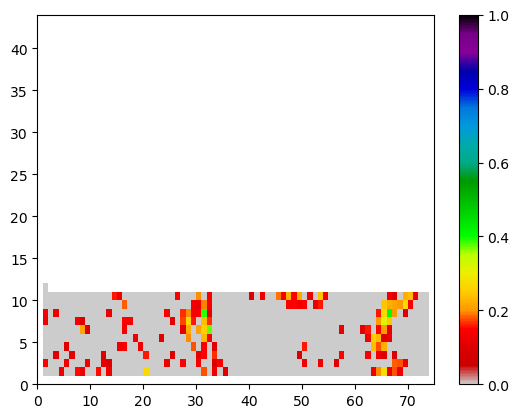

In [32]:
plt.pcolormesh(final_out[0, ...], vmin=0, vmax=1.0, cmap=plt.cm.nipy_spectral_r)
plt.colorbar()

In [35]:
zarr.save(temp_dir+'CONVNEXT_Base_pp19_tune3'+'_lead{}_prob.zarr'.format(lead), final_out)

In [3]:
temp_dir = '/glade/work/ksha/NCAR/Keras_models/'

In [ ]:
def domain_group(data, gap=24):
    
    assert gap >= 2

    
    grid_shape = data.shape
    Nx = grid_shape[0] // gap + 1
    Ny = grid_shape[1] // gap + 1
    
    edgex = gap*Nx
    edgey = gap*Ny
    
    if (edgex > grid_shape[0]+1):
        Nx -= 1
    
    if (edgey > grid_shape[1]+1):
        Ny -= 1
        
    out = np.empty((Nx, Ny))
    
    for ix in range(Nx):
        for iy in range(Ny):
            if method == 'mean':
                out[ix, iy] = np.nanmean(data[ix*gap:(ix+1)*gap, iy*gap:(iy+1)*gap])
            elif method == 'min':
                out[ix, iy] = np.nanmin(data[ix*gap:(ix+1)*gap, iy*gap:(iy+1)*gap])
            else:
                out[ix, iy] = np.nanmax(data[ix*gap:(ix+1)*gap, iy*gap:(iy+1)*gap])
    return out